# Preamble

*Here you put configuration variables and essential imports*

In [1]:
# Essential modules
import os, re, sys

# Load environmental variables
PROJECT_NAME = os.environ['PROJECT_NAME']
STORAGE      = os.environ['STORAGE']

# Set the root of the project
workdir = re.sub(r"(?<={})[\w\W]*".format(PROJECT_NAME), "", os.getcwd())
os.chdir(workdir)
sys.path.append("/home/mateusz/pyspark/pyspark-modeling")

### Imports  
*All the other Python imports go here.*

In [2]:
import numpy as np
import pandas as pd
import pyspark
import pyspark.sql
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from google.cloud import storage
import pyspark.sql.functions as f

import matplotlib.pyplot as plt
import seaborn as sns


print("pyspark.__version__")
print(pyspark.__version__)

pyspark.__version__
3.0.1


### Settings

Any settings go here, for example:
```
pd.options.mode.chained_assignment = None  # default='warn'
```

In [3]:
%load_ext autotime

--- 
# Main code

### Functions

In [4]:
def create_spark_session():
    sc = SparkContext.getOrCreate()
    spark = SparkSession(sc)
    return spark, sc

time: 933 µs


### Init spark session

In [5]:
try:
    sc.stop()
except:
    print("There is no SparkContext...")

There is no SparkContext...
time: 7.05 ms


In [6]:
spark, sc = create_spark_session()

time: 15.5 s


### Import dataframe

In [7]:
path = "gs://" + STORAGE + "/data/health-insurance/train.csv"

time: 600 µs


#### Pandas

In [8]:
# df = pd.read_csv(filepath_or_buffer=path)
# print(df.head(2))

# del df

time: 480 µs


#### Pyspark

In [9]:
df_spark = spark.read.csv(path=path, header=True)\
    .withColumn("Region_Code", f.col("Region_Code").cast("Integer"))\
    .withColumn("Driving_License", f.col("Driving_License").cast("Integer"))\
    .withColumn("id", f.col("id").cast("Integer"))\
    .withColumn("Age", f.col("Age").cast("Integer"))\
    .withColumn("Previously_Insured", f.col("Previously_Insured").cast("Integer"))\
    .withColumn("Annual_Premium", f.col("Annual_Premium").cast("Integer"))\
    .withColumn("Policy_Sales_Channel", f.col("Policy_Sales_Channel").cast("Integer"))\
    .withColumn("Vintage", f.col("Vintage").cast("Integer"))\
    .withColumn("Response", f.col("Response").cast("Integer"))

df_spark.show(2)

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  1|  Male| 44|              1|         28|                 0|  > 2 Years|           Yes|         40454|                  26|    217|       1|
|  2|  Male| 76|              1|          3|                 0|   1-2 Year|            No|         33536|                  26|    183|       0|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
only showing top 2 rows

time: 16 s


### Description of df

https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

- **id** - id klienta
- **Gender** - płeć
- **Age** - wiek
- **Driving_License** - czy ma prawo jazdy
- **Region_Code** - kod regionu
- **Previously_Insured** - 1 : klient posiada już ubezp na auto, 0 : nie posiada
- **Vehicle_Age** - wiek auta
- **Vehicle_Damage** - 1: klient miał zniszczony w przeszłości samochód
- **Annual_Premium** - tyle co roku musi klient płacić
- **Policy_Sales_Channel** - kanał sprzedaży (zanonimizowane)
- **Vintage** - ile dni klient jest z ubezpieczalnią
- **Response** - label - 1 - dostał ubezpieczenie


## EDA

In [10]:
df_spark.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Driving_License: integer (nullable = true)
 |-- Region_Code: integer (nullable = true)
 |-- Previously_Insured: integer (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: integer (nullable = true)
 |-- Policy_Sales_Channel: integer (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Response: integer (nullable = true)

time: 13.6 ms


### Describe numerical

In [11]:
numerical_cols = ["Age", "Driving_License", "Region_Code", "Previously_Insured", "Annual_Premium", "Policy_Sales_Channel", "Vintage", "Response"] 
df_spark.select(numerical_cols).describe().show()

+-------+------------------+-------------------+------------------+-------------------+------------------+--------------------+------------------+-------------------+
|summary|               Age|    Driving_License|       Region_Code| Previously_Insured|    Annual_Premium|Policy_Sales_Channel|           Vintage|           Response|
+-------+------------------+-------------------+------------------+-------------------+------------------+--------------------+------------------+-------------------+
|  count|            381109|             381109|            381109|             381109|            381109|              381109|            381109|             381109|
|   mean|38.822583565331705| 0.9978693759528114|26.388807401557035| 0.4582101183650871|30564.389581458323|  112.03429465061177|154.34739667654136|0.12256336113815208|
| stddev|15.511611018095289|0.04610954420779939| 13.22988802578849|0.49825119888722647| 17213.15505698001|   54.20399477485634| 83.67130362658735|0.32793576478642567

In [12]:
df_spark.show(1)

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  1|  Male| 44|              1|         28|                 0|  > 2 Years|           Yes|         40454|                  26|    217|       1|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
only showing top 1 row

time: 1.26 s


In [13]:
df_spark.columns

['id',
 'Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

time: 82.1 ms


In [14]:
df_spark.count(), len(df_spark.columns)

(381109, 12)

time: 1.47 s


### Null values

In [15]:
df_spark.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in df_spark.columns]).show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  0|     0|  0|              0|          0|                 0|          0|             0|             0|                   0|      0|       0|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+

time: 3.11 s


### Value counts

In [20]:
columns_value_counts = ["Gender", "Driving_License", "Region_Code", 
                        "Previously_Insured", "Policy_Sales_Channel", 
                        "Vintage", "Response", "Vehicle_Damage"]

for col in columns_value_counts:
    df_spark.groupby(f.col(col)).count().sort(f.col("count").desc()).show()

+------+------+
|Gender| count|
+------+------+
|  Male|206089|
|Female|175020|
+------+------+

+---------------+------+
|Driving_License| count|
+---------------+------+
|              1|380297|
|              0|   812|
+---------------+------+

+-----------+------+
|Region_Code| count|
+-----------+------+
|         28|106415|
|          8| 33877|
|         46| 19749|
|         41| 18263|
|         15| 13308|
|         30| 12191|
|         29| 11065|
|         50| 10243|
|          3|  9251|
|         11|  9232|
|         36|  8797|
|         33|  7654|
|         47|  7436|
|         35|  6942|
|          6|  6280|
|         45|  5605|
|         37|  5501|
|         18|  5153|
|         48|  4681|
|         14|  4678|
+-----------+------+
only showing top 20 rows

+------------------+------+
|Previously_Insured| count|
+------------------+------+
|                 0|206481|
|                 1|174628|
+------------------+------+

+--------------------+------+
|Policy_Sales_Channel| 

### Histograms of age, premium and vintage

<AxesSubplot:ylabel='Frequency'>

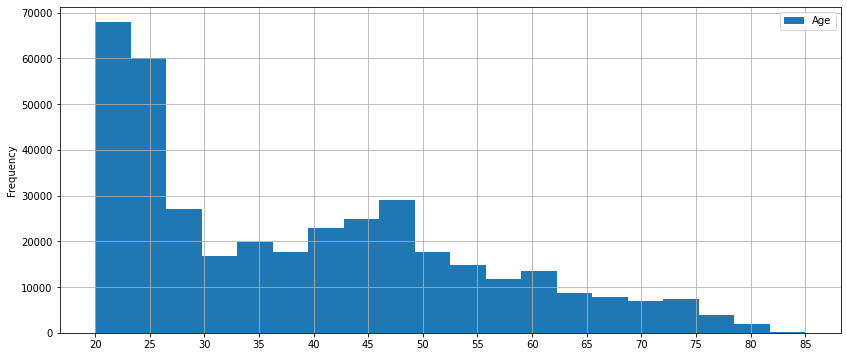

time: 4.25 s


In [17]:
df_spark.select("Age").toPandas().plot(kind="hist", 
                                       figsize=(14, 6), 
                                       bins=20, 
                                       xticks=[x * 5 for x in range(4, 18)], 
                                       grid=True)

In [18]:
print("DataFrame length:", df_spark.count())

print("10000 - 100000:", df_spark.filter((df_spark.Annual_Premium > 10000) & (df_spark.Annual_Premium < 100000)).select("Annual_Premium").count())

print("100000+", df_spark.filter(df_spark.Annual_Premium < 100000).select("Annual_Premium").count())

print("Below 10000:", df_spark.filter(df_spark.Annual_Premium > 10000).select("Annual_Premium").count())

DataFrame length: 381109
10000 - 100000: 315449
100000+ 380331
Below 10000: 316227
time: 6.23 s


In [19]:
df_spark.filter((df_spark.Annual_Premium > 10000) & (df_spark.Annual_Premium < 100000)).select("Annual_Premium").toPandas().plot(kind="hist", 
                                                                                                                                 figsize=(14, 6), 
                                                                                                                                 bins=30, 
               t                                                                                                                  xticks=[x * 10000 for x in range(1, 10)], 
                                                                                                                                 grid=True)

SyntaxError: invalid syntax (<ipython-input-19-e5a7f8de32b4>, line 4)

time: 2.93 ms


In [ ]:
df_spark.select("Vintage").toPandas().plot(kind="hist", 
                                           figsize=(14, 6), 
                                           grid=True)

### Make age into bins

In [ ]:
"""
Test why this doesn't work
"""


# from Transformers.NumericalToBins import NumericalToBins

# splitsy = [x * 5 for x in range(4, 18)]
# t = {}
# for x in range(0, 13):
#     t[x] = str((x + 4) * 5) + "-" + str((x + 5) * 5)

# df_tmp = NumericalToBins(inputCol="Age", 
#                          outputCol="age_bins", 
#                          splits=splitsy, 
#                          names_dict=t).transform(df_spark)
# df_tmp.show(2)

In [ ]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import *
bucketizer = Bucketizer(splits=[x * 5 for x in range(4, 18)], inputCol="Age", outputCol="age_bins")
t = {}
for x in range(0, 14):
    t[x] = str((x + 4) * 5) + "-" + str((x + 5) * 5)

udf_foo = f.udf(lambda x: t[x], StringType())
# df_spark.select("Age")
df_buck = bucketizer.setHandleInvalid("keep").transform(df_spark)
df_spark = df_buck.withColumn("age_bins", udf_foo("age_bins"))
df_spark.show(5)

### Make annual premium into bins

In [ ]:
from Transformers.DropColumns import DropColumns

In [ ]:
df_buck.show(2)

In [ ]:
splits = [0, 10000, 20000, 30000, 40000, 50000, 60000, 1000000]
t = {0: "0-10000", 1: "10000-20000", 2: "20000-30000", 3: "30000-40000", 4: "40000-50000",
    5: "50000-60000", 6: "60000+"}
bucketizer = Bucketizer(splits=splits, inputCol="Annual_Premium", outputCol="annual_premium_bins")

udf_foo = f.udf(lambda x: t[x], StringType())
df_buck = bucketizer.setHandleInvalid("keep").transform(df_spark)

df_spark = df_buck.withColumn("annual_premium_bins", udf_foo("annual_premium_bins"))
df_spark.show(5)


### Make vintage into bins

In [ ]:
splits = [0, 50, 100, 150, 200, 250, 300]
t = {0: "0-50", 1: "50-100", 2: "100-150", 3: "150-200", 4: "200-250",
    5: "250-300"}

bucketizer = Bucketizer(splits=splits, inputCol="Vintage", outputCol="vintage_bins")

udf_foo = f.udf(lambda x: t[x], StringType())
df_buck = bucketizer.setHandleInvalid("keep").transform(df_spark)

df_spark = df_buck.withColumn("vintage_bins", udf_foo("vintage_bins"))
df_spark.show(5)


### Pivot table - age_bins & Response

In [ ]:
def pivot_table(df, col1, col2):
    df_tmp = df.groupBy(col1).pivot(col2).count().sort(f.col(col1).desc())
    df_tmp = df_tmp.withColumn(colName="normalized", col=f.round(f.col("0") / (f.col("0") + f.col("1")), 3) )
    df_tmp.show()
    del df_tmp


In [ ]:
df_tmp = df_spark.groupBy("age_bins").pivot("Response").count().sort(f.col("age_bins").desc())
df_tmp = df_tmp.withColumn(colName="normalized", col=f.round(f.col("0") / (f.col("0") + f.col("1")), 3) )
df_tmp.show(2)

In [ ]:
pivot_table(df_spark, "age_bins", "Response")

### Pivot table - annual_prem & Response 

In [ ]:
pivot_table(df_spark, "annual_premium_bins", "Response")

### Pivot table - vintage & Response

In [ ]:
pivot_table(df_spark, "vintage_bins", "Response")

### Age & annual prem

In [ ]:
df_spark.show(2)

In [ ]:
df_tmp = df_spark.select(["Age", "Annual_Premium"]).toPandas()
df_tmp

In [ ]:
sns.scatterplot(x=df_tmp["Age"], y=df_tmp["Annual_Premium"])

### Previous_insured & Response

In [ ]:
df_spark.show(1)

In [ ]:
df_tmp = df_spark.select(["Previously_Insured", "Response"]).toPandas()
df_tmp

In [ ]:
df_tmp.loc[df_tmp["Response"] == 1]["Previously_Insured"].value_counts()

In [ ]:
sns.catplot(x="Previously_Insured", 
#             y="sd",
            col="Response", 
            data=df_tmp, 
            kind="count")

### Vehicle_age

In [ ]:
df_tmp = df_spark.select("Vehicle_Age").toPandas()
df_tmp

In [ ]:
sns.countplot(df_tmp["Vehicle_Age"])

### Damage_Vehicle & Response

--- 
# Leftovers
*Here you leave any code snippets or temporary code that you don't need but don't want to delete just yet.*

In [ ]:
def foo(names:dict = None):
    
    if names:
        print(names["key"])
    else:
        print("NOTHING HERE")

In [ ]:
t = {"key": "val"}
foo()

In [ ]:
df_tmp = df_spark.groupBy("age_bins").pivot("Response").count().sort(f.col("age_bins").desc())
df_tmp = df_tmp.withColumn(colName="normalized", col=f.round(f.col("0") / (f.col("0") + f.col("1")), 3) )
df_tmp.show(2)